# ***Stability Within the Mandelbrot***

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random

# Generated Data Import and Parsing

In [42]:
import pandas as pd

# Specifying the file path
file_path = '/s/bach/a/class/cs435/cs435f/Zack_workspace/small_processed_fixed.csv'
#file_path ='/s/bach/a/class/cs435/cs435f/Zack_workspace/csv_iterations_d06/processed_iterations.csv'

# Reading the CSV with space as delimiter
dataframe = pd.read_csv(file_path, sep=' ', header=None)#, nrows=300000, skiprows=900000)


# Split the first column into multiple columns and drop the first two columns
dataframe = dataframe.iloc[:, 0].str.split(' ', expand=True)
dataframe.drop(columns=[0, 1,55,53,52], inplace=True)

# Generate new column names for all but the last column
new_column_names = [f"iter_{i//2 + 1}_{'x' if i % 2 == 0 else 'y'}" for i in range(dataframe.shape[1] - 1)]
new_column_names.append('labels_100')  # Name for the last column

# Assign the new column names to the DataFrame
dataframe.columns = new_column_names
dataframe = dataframe.astype(float)

# Display the DataFrame with new column names
print(dataframe)
print(dataframe.iloc[:, -1].value_counts(1))

        iter_1_x  iter_1_y  iter_2_x  iter_2_y  iter_3_x  iter_3_y  iter_4_x  \
0       0.384645 -0.030521  0.531665 -0.054001  0.664397 -0.087942  0.818335   
1      -1.188578  0.226516  0.172830 -0.311947 -1.256019  0.118688  0.374918   
2      -0.982126 -0.326051 -0.123864  0.314395 -1.065629 -0.403935 -0.009726   
3      -1.014577  0.320080 -0.087662 -0.329411 -1.115404  0.377833  0.086791   
4      -0.528832  0.502580 -0.501756 -0.028980 -0.277913  0.531663 -0.734261   
...          ...       ...       ...       ...       ...       ...       ...   
299995 -1.365221 -0.000079  0.498607  0.000137 -1.116612  0.000057 -0.118399   
299996 -0.340905 -0.591570 -0.574644 -0.188232 -0.046121 -0.375238 -0.479581   
299997 -1.177233 -0.162083  0.182373  0.219535 -1.192168 -0.082008  0.237307   
299998 -0.052730 -0.696342 -0.534842 -0.622906 -0.154686 -0.030029 -0.029704   
299999  0.347708 -0.324809  0.363108 -0.550687  0.176300 -0.724727 -0.146440   

        iter_4_y  iter_5_x  iter_5_y  .

# Display Funtions
These two functions display our data using matpltlib. For clarity we only plot the stable points. *display_points* is the standard display function and *display_dif* displays the difference between different amount of iterations

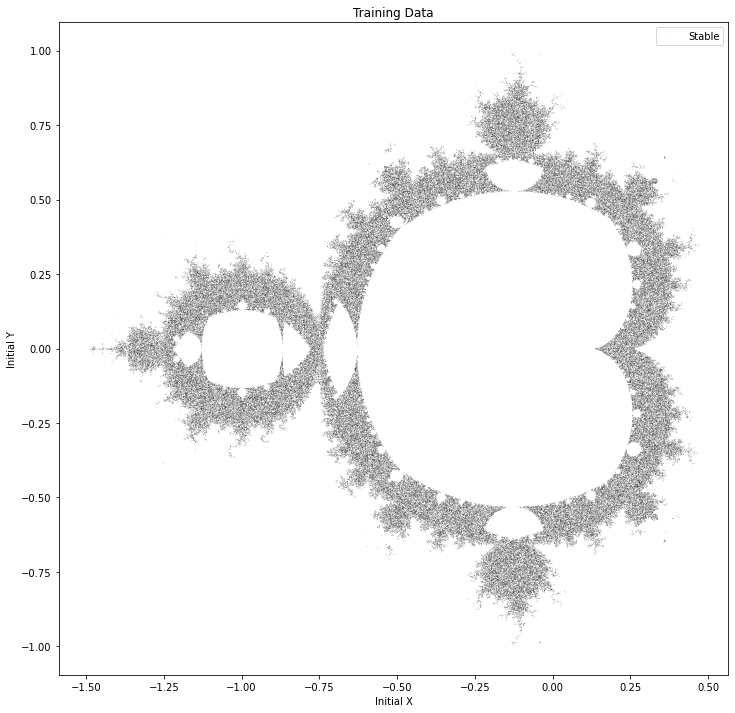

In [43]:
def display_points(data_df, labels, size, title):
    # Filtering the DataFrame based on the 'converged' column
    plt.figure(figsize=(12, 12))

    converged_points = data_df[data_df[labels] == 1]
    #diverged_points = data_df[data_df['labels'] == 0]


    # Creating a scatter plot for converged points in black
    plt.scatter(converged_points['iter_1_x'], converged_points['iter_1_y'], c='black', label='Stable', s=size)

    # Creating a scatter plot for diverged points in red
    #plt.scatter(diverged_points['iter_1_x'], diverged_points['iter_1_y'], c='red', label='Diverged',s=.001)
    #
    # Adding labels and title
    plt.xlabel('Initial X')
    plt.ylabel('Initial Y')
    plt.title(title)
    plt.legend()

    # Displaying the plot

    plt.show()
    
def display_dif(data_df, data_df_1, labels, labels1, size, title, color='red'):
    # Filtering the DataFrame based on the 'converged' column
    plt.figure(figsize=(15, 15))

    converged_points = data_df[data_df[labels] == 1]
    converged_points_1 = data_df_1[data_df_1[labels1] == 1]
    #diverged_points = data_df[data_df[labels] == 0]


    # Creating a scatter plot for converged points in black
    plt.scatter(converged_points_1['iter_1_x'], converged_points_1['iter_1_y'], c= color, s=size)
    plt.scatter(converged_points['iter_1_x'], converged_points['iter_1_y'], c='black', s=size)
    
    

    # Creating a scatter plot for diverged points in red
    #plt.scatter(diverged_points['iter_1_x'], diverged_points['iter_1_y'], c='red', label='Diverged',s=.001)
    #
    # Adding labels and title
    plt.xlabel('Initial X')
    plt.ylabel('Initial Y')
    plt.title(title)
    plt.legend()

    # Displaying the plot

    plt.show()

display_points(dataframe, 'labels_100', .001, "Training Data" )

# Testing Data Generation

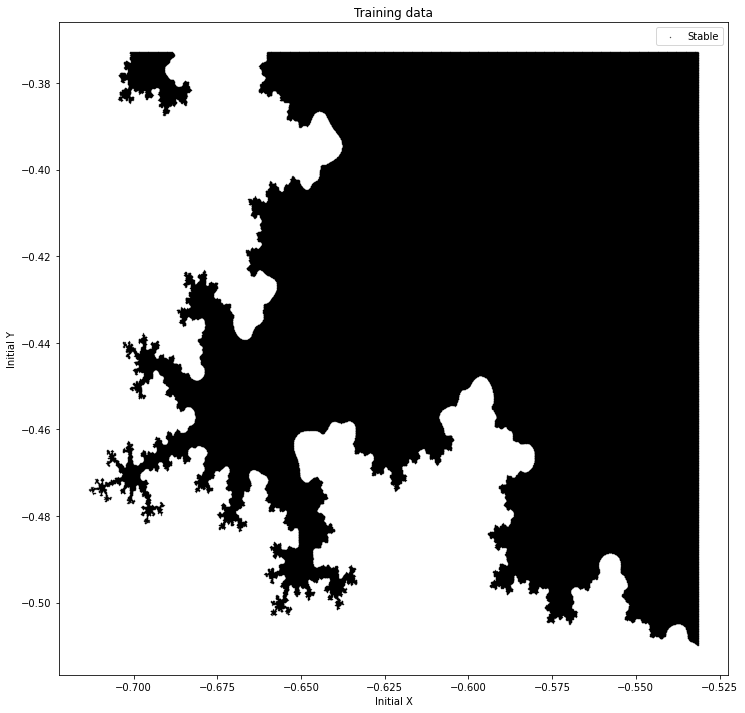

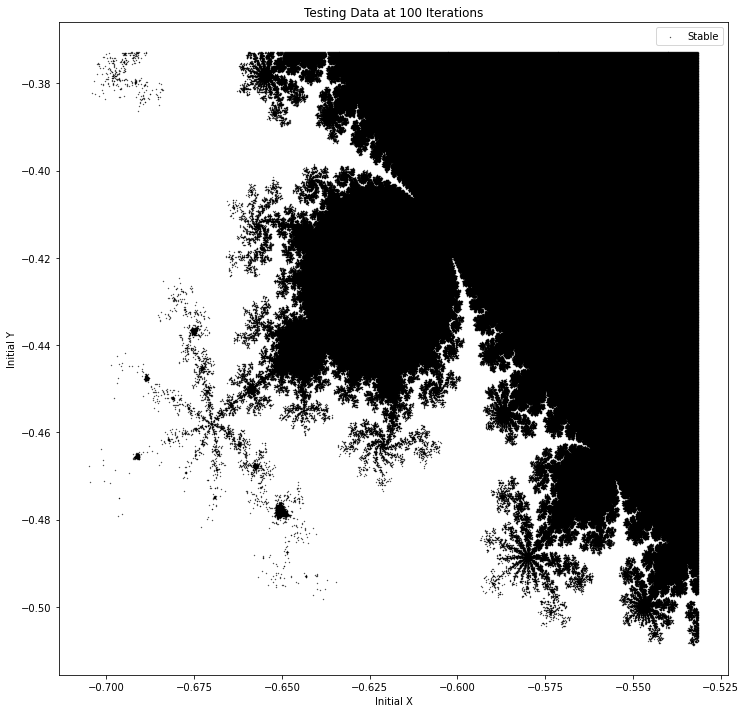

In [54]:
#MAX_ITER = 200
#RECORD_ITER = 25

def mandelbrot_iterations(c, max_iter=100, record_iter=25):
    iterations = []
    z = 0
    converged_25 = None
    converged_100 = None
    for n in range(max_iter):
        if abs(z) > 2:
            if converged_25 is None and n >= 25:
                converged_25 = 0
            if converged_100 is None:
                converged_100 = 0
            break

        z = z*z + c
        if n < record_iter:
            iterations.append((z.real, z.imag))

        if n == 24:
            converged_25 = 1
        if n == 99:
            converged_100 = 1

    if converged_25 is None:
        converged_25 = 0
    if converged_100 is None:
        converged_100 = 0

    return iterations, converged_25, converged_100

def generate_mandelbrot_points(xmin, xmax, ymin, ymax, width, height):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)

    points = []
    for i in range(len(r1)):
        for j in range(len(r2)):
            c = complex(r1[i], r2[j])
            iterations, converged_25, converged_100 = mandelbrot_iterations(c)  
            points.append((r1[i], r2[j], iterations, converged_25, converged_100))  # Include the two convergence results
    return points


def convert_points_to_dataframe(points, record_iter=25):
    columns = ['iter_0_x', 'iter_0_y']
    for i in range(record_iter):
        columns.append(f'iter_{i+1}_x')
        columns.append(f'iter_{i+1}_y')
    columns.extend(['labels_25', 'labels_100'])

    data = []
    for point in points:
        x, y, iterations, converged_25, converged_100 = point
        iterations_flat = [val for sublist in iterations for val in sublist] + \
                          [0] * 2 * (record_iter - len(iterations))
        row = [x, y] + iterations_flat + [converged_25, converged_100]
        data.append(row)

    df = pd.DataFrame(data, columns=columns)
    return df


# Parameters for generating Mandelbrot points
xmin, xmax, ymin, ymax = -0.744037635324, -0.531473121232, -0.372826637842, -0.516842880350
#xmin, xmax, ymin, ymax = -1.5, .5, -1, 1
width, height = 1500, 1500

# Using the functions
points = generate_mandelbrot_points(xmin, xmax, ymin, ymax, width, height)
test_data_df = convert_points_to_dataframe(points)

display_points(test_data_df, 'labels_25', .1, "Training data")
display_points(test_data_df, 'labels_100', .1, "Testing Data at 100 Iterations")

xmin, xmax, ymin, ymax = -.25, .25, -.25, .25
width, height = 100, 100





No handles with labels found to put in legend.


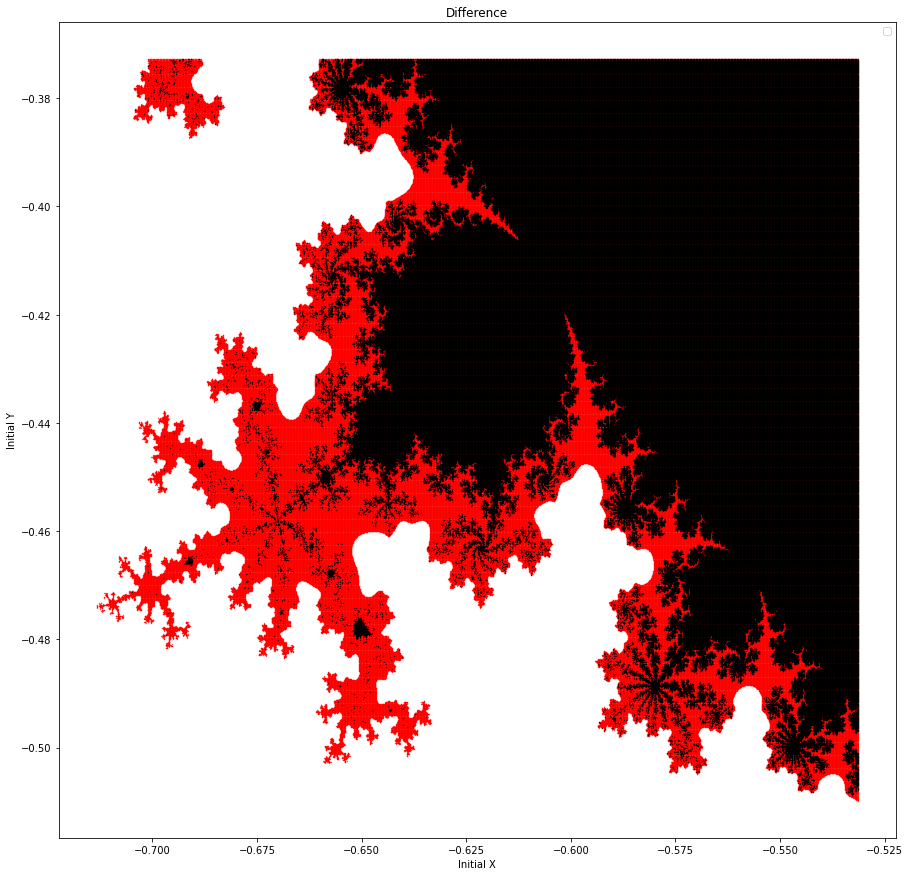

In [55]:
display_dif(test_data_df, test_data_df, 'labels_100', 'labels_25', .1, "Difference")

# Data Reshaping

In [56]:
from sklearn.model_selection import train_test_split

#dataframe = test_data_df.drop(columns = ['labels_25', 'iter_0_x', 'iter_0_y'])


Labels = dataframe.iloc[:, -1]
Iter = dataframe.drop(columns = ['labels_100'])

Labels = dataframe.iloc[:, -1]
Iter = dataframe.drop(columns = ['labels_100'])

X_train, X_test, y_train, y_test = train_test_split(Iter, Labels, test_size=0.2, random_state=42)

In [57]:
from torch.utils.data import DataLoader, TensorDataset
def dataframe_to_tensor(df, num_features, num_channels=2):
    num_samples = len(df)

    # Calculate the total number of expected elements after reshaping
    total_elements_expected = num_samples * num_features * num_channels

    # Check if the DataFrame has the correct number of columns
    if df.shape[1] != total_elements_expected // num_samples:
        raise ValueError(f"DataFrame has incorrect number of columns. Expected: {total_elements_expected // num_samples}, Found: {df.shape[1]}")

    # Convert DataFrame to numpy array and ensure the type is float32 for PyTorch compatibility
    df_np = df.to_numpy(dtype=np.float32)

    # Reshape to (num_samples, num_features, num_channels)
    # and then swap the last two dimensions to get (num_samples, num_channels, num_features)
    df_np = df_np.reshape(num_samples, num_features, num_channels)
    df_np = np.swapaxes(df_np, 1, 2)

    # Convert to PyTorch tensor
    return torch.tensor(df_np)


In [58]:
X_train_tensor = dataframe_to_tensor(X_train, num_features=25)
y_train_tensor = torch.tensor(y_train.to_numpy(dtype=np.float32), dtype=torch.float32).view(-1, 1)

In [59]:
X_test_tensor = dataframe_to_tensor(X_test, num_features=25)
y_test_tensor = torch.tensor(y_test.to_numpy(dtype=np.float32), dtype=torch.float32).view(-1, 1)

In [60]:
Labels_25 = test_data_df.iloc[:, -2]
Labels_100 = test_data_df.iloc[:, -1]
po = test_data_df.drop(columns = ['iter_0_x', 'iter_0_y'])
X_Y = po.iloc[:, :2]
Iter_test = test_data_df.drop(columns = ['labels_100', 'labels_25', 'iter_0_x', 'iter_0_y'])

X_zoom_tensor = dataframe_to_tensor(Iter_test, num_features=25)
y_25_tesnor = torch.tensor(Labels_25.to_numpy(dtype=np.float32), dtype=torch.float32).view(-1, 1)
y_100_tesnor = torch.tensor(Labels_100.to_numpy(dtype=np.float32), dtype=torch.float32).view(-1, 1)

# 1D CNN 

Epoch [1/2], Loss: 0.013061398640275002, Time: 58.740657567977905 seconds
Epoch [2/2], Loss: 3.1852844131208258e-06, Time: 63.248316049575806 seconds
Total training time: 121.98927187919617 seconds


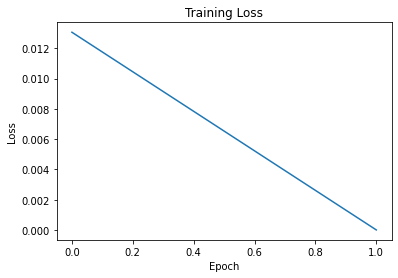

Training Accuracy: 99.54666666666667%
Testing Accuracy: 99.53%


In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import time

class Binary1DCNN(nn.Module):
    def __init__(self, input_length):
        super(Binary1DCNN, self).__init__()

        # More layers with fewer filters
        self.conv1 = nn.Conv1d(2, 16, kernel_size=2, stride=1, padding=0)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1) 
        self.conv5 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1) 
        self.conv6 = nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1) 
        
        self.pool = nn.MaxPool1d(kernel_size=1, stride=2, padding=0)

        # Adjust the fully connected layers
        self.fc_input_size = 512  
        self.fc1 = nn.Linear(self.fc_input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = self.pool(F.leaky_relu(self.conv4(x)))  
        x = self.pool(F.leaky_relu(self.conv5(x)))  
        x = self.pool(F.leaky_relu(self.conv6(x)))  
        #print(x.shape)
        x = x.view(-1, self.fc_input_size)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x




    
def use_model(model, X_test_tensor):
    """
    Function to use the trained model for prediction on test data

    Parameters:
    - model : trained model
    - X_test_tensor : test feature tensor

    Returns:
    - predictions : model predictions on test data
    """
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient computation
        outputs = model(X_test_tensor)  # Get model outputs for test data
        predictions = (outputs.data > 0.5).float()  # Convert outputs to binary predictions (0 or 1)

    return predictions.numpy()  # Return predictions as a numpy array
    

# Creating a DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Instantiate the model
model = Binary1DCNN(input_length=25)  

# Define the loss function and the optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.RMSprop(model.parameters(), lr=0.0001)

num_epochs = 2
losses = []

# Start timing the entire training process
start_time = time.time()

for epoch in range(num_epochs):
    # Start timing the current epoch
    epoch_start_time = time.time()

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    losses.append(loss.item())

    # End timing the current epoch
    epoch_end_time = time.time()

    # Calculate and print the time taken for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Time: {epoch_end_time - epoch_start_time} seconds")

# End timing the entire training process
end_time = time.time()

# Calculate and print the total time taken for the training process
print(f"Total training time: {end_time - start_time} seconds")


# Plotting the training loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()



# Calculating accuracy
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        predicted = (outputs.data > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Training Accuracy: {accuracy}%')


model.eval()
all_labels = []
all_predictions = []
   
y_pred = use_model(model, X_test_tensor)
y_true = y_test_tensor.numpy()

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred) * 100
print(f'Testing Accuracy: {accuracy:.2f}%')




# Output

Baseline Accuracy: 84.53%
Model Prediction Accuracy: 85.52%
Model Prediction Score: 0.98


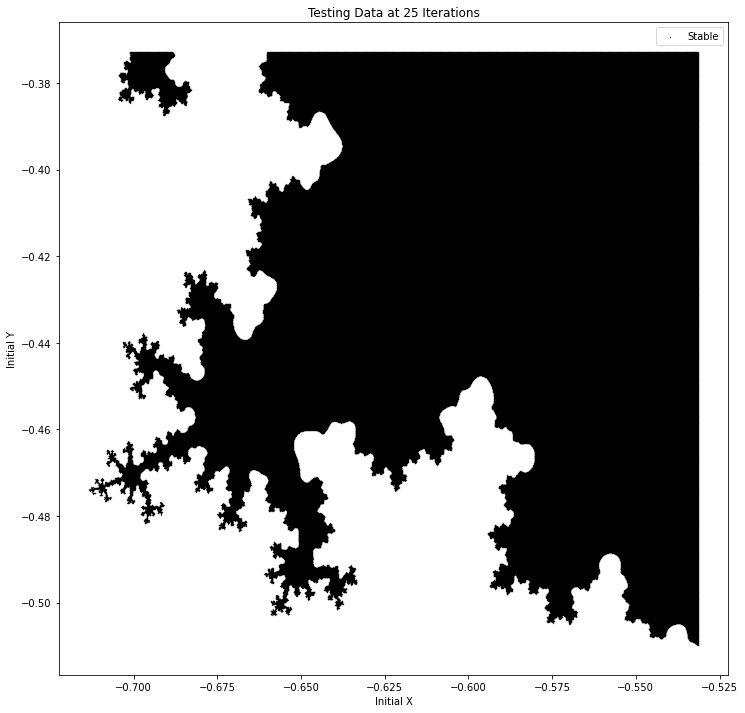

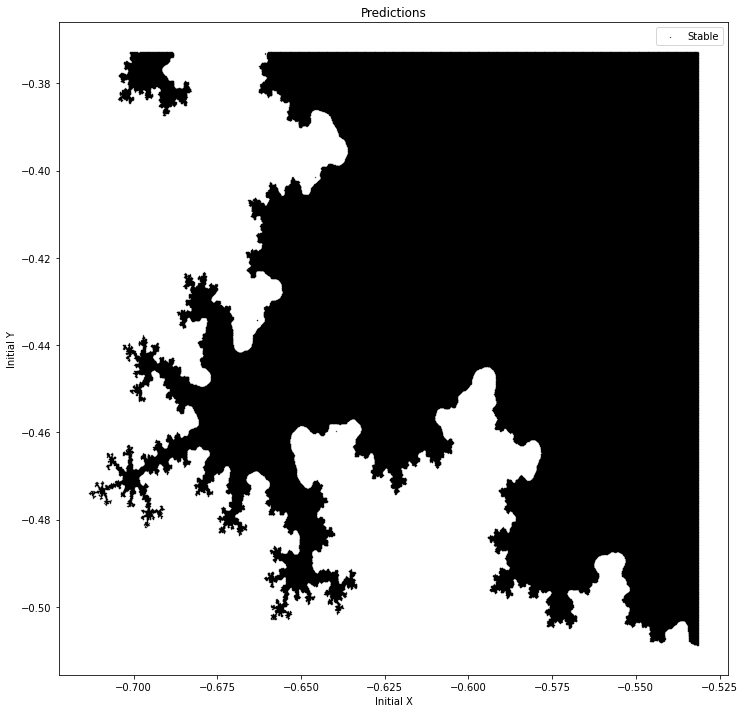

In [62]:
y_pred = use_model(model, X_zoom_tensor)
y_true_25 = y_25_tesnor.numpy()
y_true_100 = y_100_tesnor.numpy()
accuracy_baseline = accuracy_score(y_true_25, y_true_100) * 100
accuracy_100 = accuracy_score(y_true_100, y_pred) * 100
print(f'Baseline Accuracy: {accuracy_baseline:.2f}%')
print(f'Model Prediction Accuracy: {accuracy_100:.2f}%')
print(f'Model Prediction Score: {(accuracy_100-accuracy_baseline):.2f}')
Final_pred = pd.concat([X_Y, pd.DataFrame(y_pred)],axis=1)
Final_pred.columns = [*Final_pred.columns[:-1], 'labels_25']
Final_pred
display_points(test_data_df, 'labels_25', .1, "Testing Data at 25 Iterations")
display_points(Final_pred, 'labels_25', .1, "Predictions")


No handles with labels found to put in legend.


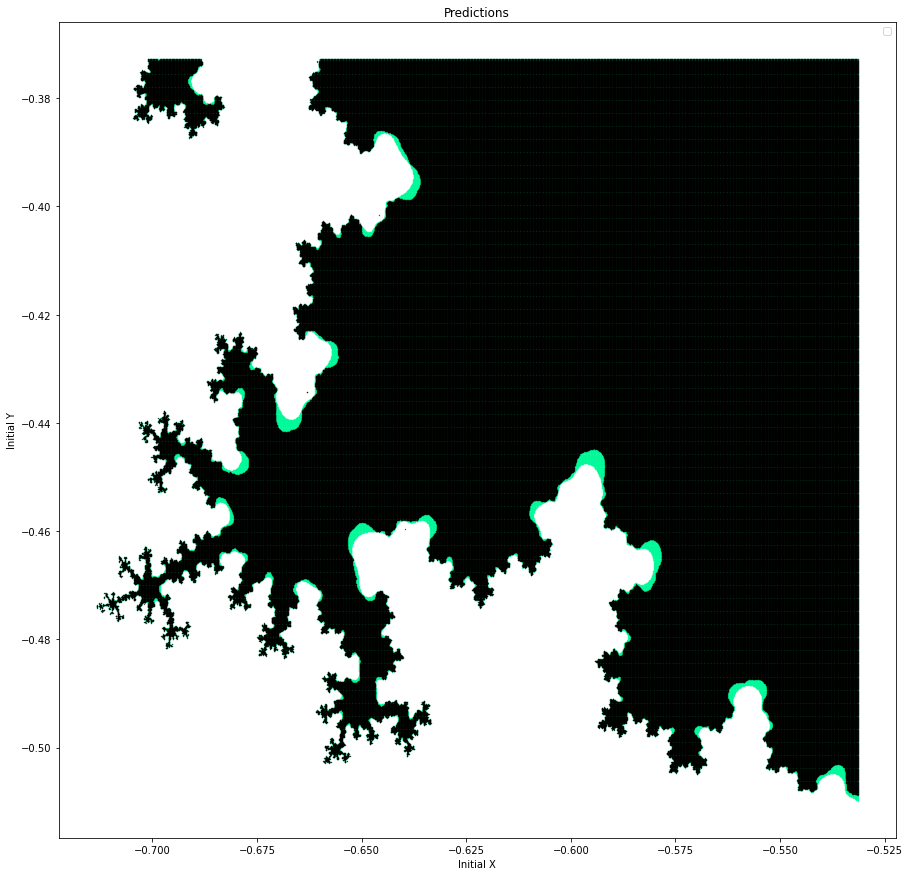

In [63]:
display_dif(Final_pred, test_data_df, 'labels_25', 'labels_25', .1, "Predictions", 'mediumspringgreen')
    
